In [2]:
from transformers import GPT2LMHeadModel

/Users/reza/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")

In [4]:
sd_hf = model_hf.state_dict()

for k,v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

In [5]:
sd_hf["transformer.wpe.weight"].view(-1).shape

torch.Size([786432])

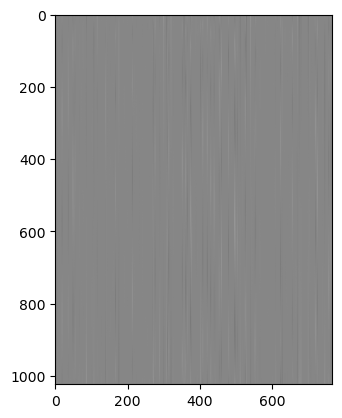

In [6]:
import matplotlib.pyplot as plt

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

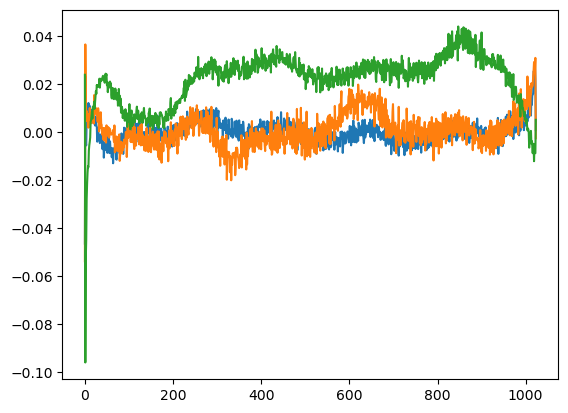

In [7]:
# sd_hf["transformer.wpe.weight"][:, 150] # --> channel 150 looking across every position

plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250]) # "This green channel likes to fire for everything up to about position 900

In [31]:
import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

# ----------------------------------------------------------

class CausalSelfAttention(nn.Module):

	def __init__(self, config):
		super().__init__()
		assert config.n_embd % config.n_head == 0

		self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd) # key, query, value projections for all heads but in a batch. Saves you from three separate instantiations of nn.Linear
		self.c_proj = nn.Linear(config.n_embd, config.n_embd) # output projection

		self.n_head = config.n_head
		self.n_embd = config.n_embd

		self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

	def forward(self, x):

		B, T, C = x.size() # batch size, sequence length, embedding dimension (n_embd)

		# Calculate query, key, value for all heads in batch, move head forward in the shape to be a batch dim alongside B
		# nh is "number of heads", hs is "head size", and C is number of channels (nh * hs)
		# e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs = 768 channels in the Transformer

		qkv = self.c_attn(x)
		q, k, v = qkv.split(self.n_embd, dim=2)
		k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
		q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
		v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

		# attention materializes the large (T, T) matrix for all queries and keys
		att = q @ k.transpose(-2, -1) * (1.0 / math.sqrt(k.size(-1))) # --> (B, nh, T, T)
		att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
		att = F.softmax(att, dim=-1)

		y = att @ v # (B, nh, T, T) x (B, nh, T, hs) --> (B, nh, T, hs)
		y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

		# output project
		y = self.c_proj(y)
		return y


class MLP(nn.Module):

	def __init__(self, config):
		super().__init__()
		self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd) # On naming (eg 'c_fc'), we are replicating the GPT2 model
		self.gelu = nn.GELU(approximate='tanh')
		self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)

	def forward(self, x):
		x = self.c_fc(x)
		x = self.gelu(x)
		x = self.c_proj(x)
		return x


class Block(nn.Module):

	def __init__(self, config):
		super().__init__()
		self.ln_1 = nn.LayerNorm(config.n_embd)
		self.attn = CausalSelfAttention(config)
		self.ln_2 = nn.LayerNorm(config.n_embd)
		self.mlp = MLP(config)		

	def forward(self, x):
		x = x + self.attn(self.ln_1(x))
		x = x + self.mlp(self.ln_2(x)) 
		return x



@dataclass
class GPTConfig:
	block_size: int = 1024 # max sequence length
	vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
	n_layer: int = 12 # number of layers
	n_head: int = 12 # number of heads
	n_embd: int = 768 # embedding dimension

class GPT(nn.Module):
	
	def __init__(self, config):
		super().__init__()
		self.config = config

		self.transformer = nn.ModuleDict(dict(
			wte = nn.Embedding(config.vocab_size, config.n_embd),
			wpe = nn.Embedding(config.block_size, config.n_embd),
			h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
			ln_f = nn.LayerNorm(config.n_embd)
		))
		self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)


	def forward(self, idx):
		# idx is shape (B, T)
		B, T = idx.size()
		assert T <= self.config.block_size, f"Cannot forward sequence of length {T}. Block size is only {self.config.block_size}"
		# forward the token and position embeddings
		pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
		pos_emb = self.transformer.wpe(pos) # shape (T, n_embd)
		tok_emb = self.transformer.wte(idx) # shape (B, T, n_embd)
		x = tok_emb + pos_emb
		# forward through the blocks of the transformer
		for block in self.transformer.h:
			x = block(x)
		# forward the final layernorm and the classifier
		x = self.transformer.ln_f(x)
		logits = self.lm_head(x) # (B, T, vocab_size)
		return logits


	@classmethod
	def from_pretrained(cls, model_type):
		"""Loads pretrained GPT-2 model weights from huggingface"""
		assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
		from transformers import GPT2LMHeadModel
		print("loading weights from pretrained gpt: %s" % model_type)

		# n_layer, n_head and n_embd are determined from model_type
		config_args = {
			'gpt2':			dict(n_layer=12, n_head=12, n_embd=768), 	# 124M params
			'gpt2-medium':	dict(n_layer=24, n_head=16, n_embd=1024), 	# 350M params
			'gpt2-large':	dict(n_layer=36, n_head=20, n_embd=1280), 	# 774M param
			'gpt2-xl':		dict(n_layer=48, n_head=25, n_embd=1600), 	# 1558M params
		}[model_type]
		config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
		config_args['block_size'] = 1024  # always 1024 for GPT model checkpoints

		# create a from-scratch initialized minGPT model
		config = GPTConfig(**config_args)
		model = GPT(config)
		sd = model.state_dict()
		sd_keys = sd.keys()
		sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # dicard the mask / buffer

		# init a huggingface/transformers model
		model_hf = GPT2LMHeadModel.from_pretrained(model_type)
		sd_hf = model_hf.state_dict()

		# copy while ensuring all of the parameters are aligned and match in names and shapes
		sd_keys_hf = sd_hf.keys()
		sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # dicard the mask / buffer
		sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # dicard the mask / buffer
		transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
		# basically the openai checkppoints use a "Conv1D" module, but we only want to use a vanilla Linear
		# this means we have to transpose these weights when we import them
		assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
		for k in sd_keys_hf:
			if any(k.endswith(w) for w in transposed):
				# special treatment for the Conv1D weights we need to transpose
				assert sd_hf[k].shape[::-1] == sd[k].shape
				with torch.no_grad():
					sd[k].copy_(sd_hf[k].t())
			else:
				assert sd_hf[k].shape == sd[k].shape
				with torch.no_grad():
					sd[k].copy_(sd_hf[k])

		return model

In [33]:
num_return_sequences = 5
max_length = 30

model = GPT.from_pretrained('gpt2')
model.eval()

loading weights from pretrained gpt: gpt2


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [45]:
x = torch.randint(0, 50000, (4,8))
# model.transformer.wte(x).shape
logits = model(x)

In [46]:
logits.shape

torch.Size([4, 8, 50257])

In [48]:
# logits.shape
logits = logits[:, -1, :]
logits.shape

torch.Size([4, 50257])

In [78]:
probs = F.softmax(logits, dim=-1)
topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
ix = torch.multinomial(topk_probs, 1)
# topk_probs
# topk_indices
# ix
xcol = torch.gather(topk_indices, -1, ix)
x = torch.cat((x, xcol), dim=1)
x

tensor([[14776,  4277, 28302, 41238,   404,    41, 20330, 47006,   290,    13,
           198,   532,    13,    34,    30,    51,    11],
        [48931, 45536,  2422, 14026, 23450, 42910, 13319,  5924,   281,   257,
           416,   644,   362,   257,    25,   645,   351],
        [13050, 16056, 24271, 30713, 19353,  4994,   948, 47106,    11,    11,
           287,   532,   319,    64,   543,  2548,    11],
        [39974, 33035,  4064, 33710, 45797, 43433, 32177,  3719,  1122,  1122,
          1122,  1122,  1122,  1122,  1122,  1122, 16809]])